# Interrogating deep neural networks


In this notebook, we look at some approaches and tools to probe deeper into a deep neural network. In the first part, we will examine a network that suffers from *vanishing gradients*. In the second part, we will explore the reasons behind a network result with *attribution maps*.

Through this tutorial, we can learn

* vanishing gradients
* tensorboard
* initializers for weights and biases
* attention maps

## Important note for Chrome users

Sometimes in Google Chrome you will need to modify your permissions to allow the Tensorboard interface to work interactively in this notebook. If Tensorboard is not working:

* Go to chrome://settings/content/cookies 
* Disable the "block indirect cookies" setting.

In [1]:
%load_ext tensorboard
import numpy as np
import tensorflow as tf
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomUniform, GlorotUniform
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from skimage.transform import resize
plt.style.use('ggplot')

In [2]:
# turbo color map
import matplotlib
turbo_colormap_data = [[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],[0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],[0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],[0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],[0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],[0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],[0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],[0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],[0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],[0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],[0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],[0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],[0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],[0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],[0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],[0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],[0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],[0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],[0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],[0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],[0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],[0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],[0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],[0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],[0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],[0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],[0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],[0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],[0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],[0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],[0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],[0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],[0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],[0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],[0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],[0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],[0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],[0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],[0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],[0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],[0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],[0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],[0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],[0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],[0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],[0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],[0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],[0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],[0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],[0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],[0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],[0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],[0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],[0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],[0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],[0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],[0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],[0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],[0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],[0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],[0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],[0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],[0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],[0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]
turbo_cmap = matplotlib.colors.ListedColormap(turbo_colormap_data)

In [3]:
def get_img_array(img_path, size):
    '''
    A helper function for reading in images
    '''
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

## Vanishing gradients

_Vanishing gradients_ is a realtively common example of an instability in training that you might encounter in deep neural networks. In deep networks sometimes the NN is not able to feed useful information back to the layers close to the start of the network during back propagation. As a result the model performs poorly or converges quickly to a sub-optimal solution. In this notebook we will look at an example of vanishing gradients, how to diagnose the problem and how to solve.

### Loading up a dataset

For this example we will look at the two circles dataset. Here the data are separated into two concentric circles. We want to build a deep neural network to classify them.

In [4]:
# generate 2d classification dataset
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)
# scale input data to [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
val_dataset = tf.data.Dataset.from_tensor_slices((testX, testy))

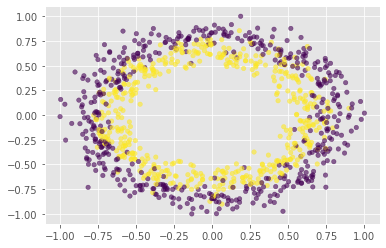

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, alpha=0.6)

### Tensorboard

We will be using **Tensorboard** to look at the behaviout of the network. To use Tensorboard you will need to have it installed and then it can talk to a Tensorflow network through a _callback_.

Callbacks are a tool that can be used to do a range of things to networks in Tensorflow during the training. For example you can monitor the training and tell the ntwork to stop the process of tr training if the loss has not improved for a certain number of steps. In this case we will use the callback to log information in a form that can be understood by Tensorboard.

We start by setting up a `logs` directory to store the relevant information. We also clear any old data that was stored previously in a `logs` directory.

Then we set up the Tensorboard callback.

In [6]:
!rm -rf logs/* # Remove all old runs
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
log_dir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

### Build a network

We start by setting up a network. In this case we will ue `tanh` activation functions for our layers. As explained in the lecture `tanh` can be partiuclarly succeptible to vanishing gradients. 

The callback is added to the network in the `fit` function. Note, you can add multiple callbacks.

In [7]:
# define model
init = RandomUniform(minval=0, maxval=1)
model = tf.keras.models.Sequential([
Dense(5, input_dim=2, activation='tanh', kernel_initializer=init, name='dense_0_t'),
Dense(5, activation='tanh', kernel_initializer=init, name='dense_1_t'),
Dense(5, activation='tanh', kernel_initializer=init, name='dense_2_t'),
Dense(5, activation='tanh', kernel_initializer=init, name='dense_3_t'),
Dense(5, activation='tanh', kernel_initializer=init, name='dense_4_t'),
Dense(5, activation='tanh', kernel_initializer=init, name='dense_5_t'),
Dense(5, activation='tanh', kernel_initializer=init, name='dense_6_t'),
Dense(5, activation='tanh', kernel_initializer=init, name='dense_7_t'),
Dense(1, activation='sigmoid', kernel_initializer=init, name='dense_out_t')
])

In [8]:
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=400, verbose=2, callbacks=[tensorboard_callback])
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 1/400
16/16 - 0s - loss: 1.0596 - accuracy: 0.4680 - val_loss: 0.7367 - val_accuracy: 0.5120
Epoch 2/400
16/16 - 0s - loss: 0.7168 - accuracy: 0.4660 - val_loss: 0.7304 - val_accuracy: 0.4860
Epoch 3/400
16/16 - 0s - loss: 0.7023 - accuracy: 0.5300 - val_loss: 0.7036 - val_accuracy: 0.4920
Epoch 4/400
16/16 - 0s - loss: 0.6936 - accuracy: 0.5320 - val_loss: 0.6933 - val_accuracy: 0.4940
Epoch 5/400
16/16 - 0s - loss: 0.6920 - accuracy: 0.5320 - val_loss: 0.6957 - val_accuracy: 0.4900
Epoch 6/400
16/16 - 0s - loss: 0.6925 - accuracy: 0.5320 - val_loss: 0.6978 - val_accuracy: 0.4920
Epoch 7/400
16/16 - 0s - loss: 0.6924 - accuracy: 0.5320 - val_loss: 0.6965 - val_accuracy: 0.4920
Epoch 8/400
16/16 - 0s - loss: 0.6916 - accuracy: 0.5320 - val_loss: 0.6976 - val_accuracy: 0.4920
Epoch 9/400
16/16 - 0s - loss: 0.6925 - accuracy: 0.5320 - val_loss: 0.6976 - val_accuracy: 0.4920
Epoch 10/400
16/16 - 0s - loss: 0.6922 - accuracy: 0.5320 - val_loss: 0.6954 - val_accuracy: 0.4920
Epoch 11/

16/16 - 0s - loss: 0.6933 - accuracy: 0.5320 - val_loss: 0.6984 - val_accuracy: 0.4940
Epoch 84/400
16/16 - 0s - loss: 0.6931 - accuracy: 0.5320 - val_loss: 0.6938 - val_accuracy: 0.4940
Epoch 85/400
16/16 - 0s - loss: 0.6915 - accuracy: 0.5320 - val_loss: 0.6969 - val_accuracy: 0.4940
Epoch 86/400
16/16 - 0s - loss: 0.6922 - accuracy: 0.5320 - val_loss: 0.6969 - val_accuracy: 0.4940
Epoch 87/400
16/16 - 0s - loss: 0.6916 - accuracy: 0.5320 - val_loss: 0.6952 - val_accuracy: 0.4940
Epoch 88/400
16/16 - 0s - loss: 0.6922 - accuracy: 0.5320 - val_loss: 0.6949 - val_accuracy: 0.4940
Epoch 89/400
16/16 - 0s - loss: 0.6941 - accuracy: 0.5320 - val_loss: 0.7016 - val_accuracy: 0.4940
Epoch 90/400
16/16 - 0s - loss: 0.6912 - accuracy: 0.5320 - val_loss: 0.6949 - val_accuracy: 0.4940
Epoch 91/400
16/16 - 0s - loss: 0.6918 - accuracy: 0.5320 - val_loss: 0.6956 - val_accuracy: 0.4940
Epoch 92/400
16/16 - 0s - loss: 0.6915 - accuracy: 0.5320 - val_loss: 0.6967 - val_accuracy: 0.4940
Epoch 93/400


Epoch 165/400
16/16 - 0s - loss: 0.6916 - accuracy: 0.5340 - val_loss: 0.6967 - val_accuracy: 0.4940
Epoch 166/400
16/16 - 0s - loss: 0.6914 - accuracy: 0.5340 - val_loss: 0.6980 - val_accuracy: 0.4960
Epoch 167/400
16/16 - 0s - loss: 0.6915 - accuracy: 0.5340 - val_loss: 0.6962 - val_accuracy: 0.4960
Epoch 168/400
16/16 - 0s - loss: 0.6914 - accuracy: 0.5340 - val_loss: 0.6960 - val_accuracy: 0.4960
Epoch 169/400
16/16 - 0s - loss: 0.6914 - accuracy: 0.5340 - val_loss: 0.6959 - val_accuracy: 0.4960
Epoch 170/400
16/16 - 0s - loss: 0.6928 - accuracy: 0.5340 - val_loss: 0.6981 - val_accuracy: 0.4960
Epoch 171/400
16/16 - 0s - loss: 0.6910 - accuracy: 0.5340 - val_loss: 0.6953 - val_accuracy: 0.4960
Epoch 172/400
16/16 - 0s - loss: 0.6919 - accuracy: 0.5340 - val_loss: 0.6944 - val_accuracy: 0.4940
Epoch 173/400
16/16 - 0s - loss: 0.6910 - accuracy: 0.5340 - val_loss: 0.6981 - val_accuracy: 0.4960
Epoch 174/400
16/16 - 0s - loss: 0.6924 - accuracy: 0.5340 - val_loss: 0.6978 - val_accurac

16/16 - 0s - loss: 0.6916 - accuracy: 0.5340 - val_loss: 0.6959 - val_accuracy: 0.4960
Epoch 247/400
16/16 - 0s - loss: 0.6914 - accuracy: 0.5340 - val_loss: 0.6958 - val_accuracy: 0.4940
Epoch 248/400
16/16 - 0s - loss: 0.6913 - accuracy: 0.5340 - val_loss: 0.6956 - val_accuracy: 0.4960
Epoch 249/400
16/16 - 0s - loss: 0.6917 - accuracy: 0.5340 - val_loss: 0.6974 - val_accuracy: 0.4960
Epoch 250/400
16/16 - 0s - loss: 0.6919 - accuracy: 0.5340 - val_loss: 0.6953 - val_accuracy: 0.4960
Epoch 251/400
16/16 - 0s - loss: 0.6913 - accuracy: 0.5340 - val_loss: 0.6955 - val_accuracy: 0.4960
Epoch 252/400
16/16 - 0s - loss: 0.6919 - accuracy: 0.5340 - val_loss: 0.6958 - val_accuracy: 0.4960
Epoch 253/400
16/16 - 0s - loss: 0.6909 - accuracy: 0.5340 - val_loss: 0.6970 - val_accuracy: 0.4960
Epoch 254/400
16/16 - 0s - loss: 0.6916 - accuracy: 0.5340 - val_loss: 0.6975 - val_accuracy: 0.4960
Epoch 255/400
16/16 - 0s - loss: 0.6925 - accuracy: 0.5340 - val_loss: 0.6983 - val_accuracy: 0.4940
Epoc

Epoch 328/400
16/16 - 0s - loss: 0.6920 - accuracy: 0.5320 - val_loss: 0.6965 - val_accuracy: 0.4900
Epoch 329/400
16/16 - 0s - loss: 0.6916 - accuracy: 0.5320 - val_loss: 0.6964 - val_accuracy: 0.4880
Epoch 330/400
16/16 - 0s - loss: 0.6915 - accuracy: 0.5320 - val_loss: 0.6958 - val_accuracy: 0.4880
Epoch 331/400
16/16 - 0s - loss: 0.6912 - accuracy: 0.5340 - val_loss: 0.6972 - val_accuracy: 0.4920
Epoch 332/400
16/16 - 0s - loss: 0.6916 - accuracy: 0.5320 - val_loss: 0.6959 - val_accuracy: 0.4940
Epoch 333/400
16/16 - 0s - loss: 0.6912 - accuracy: 0.5340 - val_loss: 0.6964 - val_accuracy: 0.4940
Epoch 334/400
16/16 - 0s - loss: 0.6917 - accuracy: 0.5340 - val_loss: 0.6968 - val_accuracy: 0.4960
Epoch 335/400
16/16 - 0s - loss: 0.6932 - accuracy: 0.5340 - val_loss: 0.6944 - val_accuracy: 0.4940
Epoch 336/400
16/16 - 0s - loss: 0.6919 - accuracy: 0.5340 - val_loss: 0.6975 - val_accuracy: 0.4940
Epoch 337/400
16/16 - 0s - loss: 0.6916 - accuracy: 0.5340 - val_loss: 0.6954 - val_accurac

### Look at the network performanace

We will plot the accuracy and validation accuracy as a function of the training.

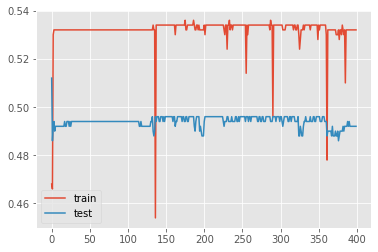

In [9]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

### Digging deeper in Tensorbaord

We can now fire up Tensorboard and take a bit of a deeper look.

In particular we are interested with how the `weights` of the layers evolve during training.

* Navigate to the `HISTOGRAMS` tab.
* Look at the details of different layers `dense_n_t`
* In particular look at the `kernel_0` histograms.

The histograms are stacked in order of training steps. The latest step at the bottom. How are the weight distributions of the kernels evolving? Are they different in initial and later layers?

In [10]:
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 49388), started 0:02:07 ago. (Use '!kill 49388' to kill it.)

### Overcoming vanishing gradients

We now use a couple of tools to counteract the problem of vanishing gradients.

* ReLU activations
* Initial distributions

`ReLU` is far less vulnerable to vanishing gradients than `tanh` so we switch the activation functions. Also initial distributions of weights can have an effect on training and affect the solution that the network finds. We switch from `RandomUniform` to `GolorotUniform`. `GolorotUniform` also draws from a random uniform distribution, but has upper and lower limits determined by the number of input and output features. It has been shown to improve training.

In [11]:
# define model
init = GlorotUniform()
modelr = tf.keras.models.Sequential([
Dense(5, input_dim=2, activation='relu', kernel_initializer=init, name='dense_0_r'),
Dense(5, activation='relu', kernel_initializer=init, name='dense_1_r'),
Dense(5, activation='relu', kernel_initializer=init, name='dense_2_r'),
Dense(5, activation='relu', kernel_initializer=init, name='dense_3_r'),
Dense(5, activation='relu', kernel_initializer=init, name='dense_4_r'),
Dense(5, activation='relu', kernel_initializer=init, name='dense_5_r'),
Dense(1, activation='sigmoid', kernel_initializer=init, name='dense_out_r')
])

# compile model
opt = SGD(lr=0.01, momentum=0.9)
modelr.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = modelr.fit(trainX, trainy, validation_data=(testX, testy), epochs=400, verbose=2, callbacks=[tensorboard_callback])
# evaluate the model
_, train_acc = modelr.evaluate(trainX, trainy, verbose=0)
_, test_acc = modelr.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 1/400
16/16 - 0s - loss: 0.6951 - accuracy: 0.4600 - val_loss: 0.6954 - val_accuracy: 0.4260
Epoch 2/400
16/16 - 0s - loss: 0.6944 - accuracy: 0.4860 - val_loss: 0.6945 - val_accuracy: 0.4520
Epoch 3/400
16/16 - 0s - loss: 0.6940 - accuracy: 0.4380 - val_loss: 0.6941 - val_accuracy: 0.4220
Epoch 4/400
16/16 - 0s - loss: 0.6940 - accuracy: 0.4900 - val_loss: 0.6939 - val_accuracy: 0.4960
Epoch 5/400
16/16 - 0s - loss: 0.6938 - accuracy: 0.5040 - val_loss: 0.6936 - val_accuracy: 0.4960
Epoch 6/400
16/16 - 0s - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.4940
Epoch 7/400
16/16 - 0s - loss: 0.6937 - accuracy: 0.4960 - val_loss: 0.6933 - val_accuracy: 0.4960
Epoch 8/400
16/16 - 0s - loss: 0.6935 - accuracy: 0.4760 - val_loss: 0.6931 - val_accuracy: 0.4960
Epoch 9/400
16/16 - 0s - loss: 0.6931 - accuracy: 0.5040 - val_loss: 0.6922 - val_accuracy: 0.4960
Epoch 10/400
16/16 - 0s - loss: 0.6920 - accuracy: 0.5040 - val_loss: 0.6917 - val_accuracy: 0.4960
Epoch 11/

Epoch 84/400
16/16 - 0s - loss: 0.5766 - accuracy: 0.7080 - val_loss: 0.5402 - val_accuracy: 0.7380
Epoch 85/400
16/16 - 0s - loss: 0.5730 - accuracy: 0.6980 - val_loss: 0.4988 - val_accuracy: 0.7940
Epoch 86/400
16/16 - 0s - loss: 0.5558 - accuracy: 0.7100 - val_loss: 0.5346 - val_accuracy: 0.7540
Epoch 87/400
16/16 - 0s - loss: 0.5547 - accuracy: 0.7140 - val_loss: 0.5246 - val_accuracy: 0.7640
Epoch 88/400
16/16 - 0s - loss: 0.5670 - accuracy: 0.7060 - val_loss: 0.5408 - val_accuracy: 0.7320
Epoch 89/400
16/16 - 0s - loss: 0.5583 - accuracy: 0.7160 - val_loss: 0.5029 - val_accuracy: 0.7740
Epoch 90/400
16/16 - 0s - loss: 0.5328 - accuracy: 0.7400 - val_loss: 0.5061 - val_accuracy: 0.7760
Epoch 91/400
16/16 - 0s - loss: 0.5495 - accuracy: 0.7040 - val_loss: 0.4902 - val_accuracy: 0.7600
Epoch 92/400
16/16 - 0s - loss: 0.6005 - accuracy: 0.7020 - val_loss: 0.6335 - val_accuracy: 0.6360
Epoch 93/400
16/16 - 0s - loss: 0.6704 - accuracy: 0.6100 - val_loss: 0.5919 - val_accuracy: 0.6680


Epoch 166/400
16/16 - 0s - loss: 0.5642 - accuracy: 0.7100 - val_loss: 0.4969 - val_accuracy: 0.7720
Epoch 167/400
16/16 - 0s - loss: 0.5693 - accuracy: 0.7040 - val_loss: 0.5678 - val_accuracy: 0.7140
Epoch 168/400
16/16 - 0s - loss: 0.5440 - accuracy: 0.7460 - val_loss: 0.5006 - val_accuracy: 0.7700
Epoch 169/400
16/16 - 0s - loss: 0.5392 - accuracy: 0.7100 - val_loss: 0.5252 - val_accuracy: 0.7480
Epoch 170/400
16/16 - 0s - loss: 0.5461 - accuracy: 0.7240 - val_loss: 0.4790 - val_accuracy: 0.7860
Epoch 171/400
16/16 - 0s - loss: 0.5288 - accuracy: 0.7240 - val_loss: 0.4715 - val_accuracy: 0.7920
Epoch 172/400
16/16 - 0s - loss: 0.5199 - accuracy: 0.7340 - val_loss: 0.4704 - val_accuracy: 0.8020
Epoch 173/400
16/16 - 0s - loss: 0.5259 - accuracy: 0.7220 - val_loss: 0.4719 - val_accuracy: 0.7920
Epoch 174/400
16/16 - 0s - loss: 0.5134 - accuracy: 0.7480 - val_loss: 0.5288 - val_accuracy: 0.7420
Epoch 175/400
16/16 - 0s - loss: 0.5163 - accuracy: 0.7440 - val_loss: 0.4689 - val_accurac

16/16 - 0s - loss: 0.4108 - accuracy: 0.8220 - val_loss: 0.5103 - val_accuracy: 0.7320
Epoch 248/400
16/16 - 0s - loss: 0.4463 - accuracy: 0.7980 - val_loss: 0.3901 - val_accuracy: 0.8300
Epoch 249/400
16/16 - 0s - loss: 0.4003 - accuracy: 0.8180 - val_loss: 0.3872 - val_accuracy: 0.8460
Epoch 250/400
16/16 - 0s - loss: 0.4177 - accuracy: 0.8040 - val_loss: 0.4341 - val_accuracy: 0.8200
Epoch 251/400
16/16 - 0s - loss: 0.4110 - accuracy: 0.8120 - val_loss: 0.3774 - val_accuracy: 0.8540
Epoch 252/400
16/16 - 0s - loss: 0.4013 - accuracy: 0.8080 - val_loss: 0.3935 - val_accuracy: 0.8360
Epoch 253/400
16/16 - 0s - loss: 0.4238 - accuracy: 0.8160 - val_loss: 0.3987 - val_accuracy: 0.8240
Epoch 254/400
16/16 - 0s - loss: 0.4081 - accuracy: 0.8160 - val_loss: 0.3970 - val_accuracy: 0.8120
Epoch 255/400
16/16 - 0s - loss: 0.4057 - accuracy: 0.8240 - val_loss: 0.3725 - val_accuracy: 0.8340
Epoch 256/400
16/16 - 0s - loss: 0.4016 - accuracy: 0.8180 - val_loss: 0.3841 - val_accuracy: 0.8460
Epoc

Epoch 329/400
16/16 - 0s - loss: 0.3860 - accuracy: 0.8320 - val_loss: 0.3840 - val_accuracy: 0.8360
Epoch 330/400
16/16 - 0s - loss: 0.3948 - accuracy: 0.8160 - val_loss: 0.3754 - val_accuracy: 0.8460
Epoch 331/400
16/16 - 0s - loss: 0.4129 - accuracy: 0.8060 - val_loss: 0.3819 - val_accuracy: 0.8460
Epoch 332/400
16/16 - 0s - loss: 0.4459 - accuracy: 0.7900 - val_loss: 0.3913 - val_accuracy: 0.8140
Epoch 333/400
16/16 - 0s - loss: 0.4064 - accuracy: 0.7960 - val_loss: 0.3883 - val_accuracy: 0.8260
Epoch 334/400
16/16 - 0s - loss: 0.3889 - accuracy: 0.8320 - val_loss: 0.4246 - val_accuracy: 0.7960
Epoch 335/400
16/16 - 0s - loss: 0.4026 - accuracy: 0.8260 - val_loss: 0.3806 - val_accuracy: 0.8400
Epoch 336/400
16/16 - 0s - loss: 0.4013 - accuracy: 0.8040 - val_loss: 0.3822 - val_accuracy: 0.8260
Epoch 337/400
16/16 - 0s - loss: 0.4020 - accuracy: 0.8120 - val_loss: 0.3709 - val_accuracy: 0.8500
Epoch 338/400
16/16 - 0s - loss: 0.3877 - accuracy: 0.8300 - val_loss: 0.3603 - val_accurac

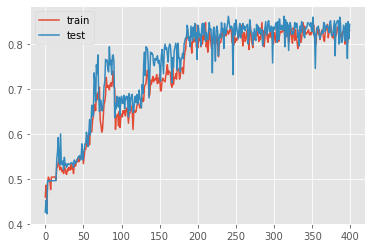

In [12]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

### Look at the weight distributions

If you return to your Tensorboard cell above. It should now contain the distributions for the new network as well as the previous one. Note that the layers in the new network have an `_r` while those in the old network have `_t`. Compare the weight distributions in the early layers of each network.

## Activation maps

We now move on to building a map to look at telling us why the network predicts what it does predict. The method that we use here is the `grad-CAM` approach and was first outlined in [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf). 

As described in the lecture we take the derivative of a class value with respect to the final convolutional filters, this tells us how strongly a filter affects a classification. We then multiply this derivative by the output of the filters and take the mean value of all of these products for the final convolutional layer. This gives us an attribution map.

<img src="https://github.com/stfc-sciml/sciml-workshop-v3/blob/master/course_3.0_with_solutions/markdown_pic/grad-cam.png?raw=1" alt="drawing" width="600"/>

### Concepts

* Getting vaules from intermediate layers
* The `GradientTape` functionality
* Pre-trained networks



In [13]:
from tensorflow import keras
# Display
from IPython.display import Image
import matplotlib.image as mpimg

### Set up the network

In this example we will use a pre-trained network and feed it a new example to classify. There are a large number of pre-trained models available in `keras` to save you always having to train from scratch. For the full list see the [`keras` applications webpage](https://keras.io/api/applications/). 

We will set up the `Xception` network 

In [14]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
# Make model
model = model_builder(weights="imagenet")

Recall from the lecture that for the `grad-CAM` we need to get values from the final convolution layer of the network. We will aslo need the names of any layers involved in the classification. Set them up here. You can always check layer names using the `model.summary()` functionality.

In [15]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

In [16]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Image to work with

We now get an example image to work with.

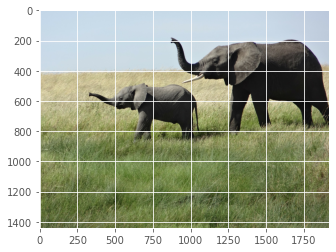

In [17]:
# The local path to our target image
img_path = keras.utils.get_file(
    "african_elephant.jpg", " https://i.imgur.com/Bvro0YD.png"
)

image = mpimg.imread(img_path)
plt.imshow(image)

### Build the map

We now write a function to build the CAM. You should be able to re-use this function for the later exercise after this lecture. There is quite a lot in the function so we will walk through in bullet points here.


#### Step 1: Get the convolution outputs from the original model

* Step 1a: Get the last convolution layer from the model
* Step 1b: Build a new model where the outputs are the values of the last convolutional layer of the original model

This is the `last_conv_layer_model`

#### Step 2: Prediction model

Here we use the outputs from the previous model and use them as input for a new model. The new model uses the same architecture as the original model to make predicions from the convolution outputs. This is the `classifier_model`

#### Step 3: Getting the gradients

Here we use the `GradientTape` functionality of tensorflow to collect the gradients of the final layer of the `last_conv_layer_model`.

* Step 3a: Run the image through the model and collect gradients of the `last_conv_layer_model`
* Step 3b: Calculate the class predictions and get the value of the top rated class
* Step 3c: Get the gradients of the convolution layers associated with the top class
* Step 3d: Perform a global averaging of each filter - gives `pooled_grads`

#### Step 4: Meultiply the gradients by the filter activations

We now take the `pooled_grads` and multiply the gradient associated with a filter by the outputs of that filter `last_conv_layer_output` and use this to generate the CAM.

* Step 4a: Multiply `last_conv_layer_output` by `pooled_grads` on a per filter basis
* Step 4b: Take the mean across all filters to build the CAM


In [18]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    
#### Step 1: Get the convolution outputs from the original model
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

#### Step 2: Prediction model
    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

#### Step 3: Getting the gradients
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
#### Step 4: Meultiply the gradients by the filter activations
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


Prepare the image for the network using the `preprocess_input` function.

In [19]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

Print out what the predicted class is.

In [20]:
# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

Predicted: [('n02504458', 'African_elephant', 0.88714474)]


Generate the CAM using the function that we just wrote. Then display

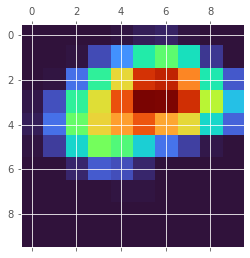

In [21]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap, cmap=turbo_cmap)
plt.show()

Resize the CAM to match the original image and display them side-by-side

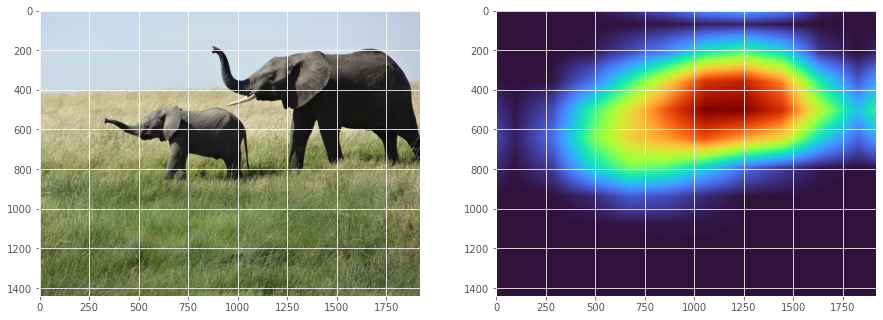

In [22]:
heatmap = resize(heatmap, (image.shape[0], image.shape[1]))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 18)
ax[0].imshow(image)
ax[1].imshow(heatmap, cmap=turbo_cmap)